# Libraries

In [1]:
from  google.colab  import  drive 
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import scipy
import math

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics.pairwise as pw
from sklearn.metrics.pairwise import pairwise_distances
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

import random
from scipy import sparse
from scipy.stats import pearsonr
import re

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import nltk
from nltk.corpus import stopwords
import torch
from torchtext import data
from torchtext import datasets

# Pre-Processing

In [6]:
#hotels = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Accommodation Reviews/hotels.csv')
#ratings = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Accommodation Reviews/ratings.csv')
#df = hotels.merge(ratings, how="left", on="HotelId")
df = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Accommodation Reviews/reviews_with_emotions_full.csv')
del df['HotelId']
del df['Unnamed: 0']
df = df.reindex(columns=['UserId', 'Name', 'Review', 'Rating', 'Emotion'])
df.head()

,UserId,Name,Review,Rating,Emotion
0,1,amalia,"Amazing hotel, great location and helpful staf...",5,admiration
1,2,amalia,"For a hotel in a world capital, our room was d...",4,admiration
2,3,amalia,We are here for 6 nights and found this Hotel ...,5,admiration
3,4,amalia,"Clean facilities, rooms. Great customer servic...",5,admiration
4,5,amalia,I have stayed In Athens in several hotels and...,5,approval


Για να ταξινομήσω τις θετικές ή τις αρνητικές κριτικές, θα συγκεντρώσω τα ratings 4 και 5 που βαθμολογήθηκαν μαζί ως θετικές και θα τις κωδικοποιήσω ως 2. Θα κωδικοποιήσω τη βαθμολογία 3 ως 0 και τη βαθμολογία 1 και 2 ως 1.

In [7]:
def calc_sentiment_with_neutral(overall):
    if overall == 5 or overall == 4:
        return 2
    elif overall == 1 or overall==2 : 
        return 0
    else:
        return 1

In [8]:
df['sentiment'] = df['Rating'].apply(calc_sentiment_with_neutral)

In [9]:
df.groupby(['sentiment','Rating']).count()

UserId   Name  Review  Emotion
sentiment Rating                                
0         1          685    685     685      685
          2          954    954     954      954
1         3         2481   2481    2481     2481
2         4         7646   7646    7646     7646
          5        12005  12005   12005    12005

In [10]:
df['sentiment'].value_counts()

2    19651
1     2481
0     1639
Name: sentiment, dtype: int64

In [11]:
df['Review']=df['Review'].str.lower()

In [12]:
df['Review']

0        amazing hotel, great location and helpful staf...
1        for a hotel in a world capital, our room was d...
2        we are here for 6 nights and found this hotel ...
3        clean facilities, rooms. great customer servic...
4        i have stayed in  athens in several hotels and...
                               ...                        
23766    i was one of the first guests and everything w...
23767    we stayed with our 2 small children on decembe...
23768    excellent service and view of athens is the gr...
23769    i was in greece for 1 night. i chose wyndham g...
23770    amazing place to enjoy a coffee  watching the ...
Name: Review, Length: 23771, dtype: object

In [13]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
def remove_punctuation(text):
    #η συνάρτηση χωρίζει τις λέξεις σε γράμματα, αφαιρεί σημεία στίξης και συγκεντρώνει ξανά γράμματα ως λέξεις
    text_no_punc = "".join([c for c in text if c not in string.punctuation])
    return text_no_punc

In [15]:
df['Review_Clean'] = df['Review'].apply(lambda x: remove_punctuation(x))
df.head()

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean
0,1,amalia,"amazing hotel, great location and helpful staf...",5,admiration,2,amazing hotel great location and helpful staff...
1,2,amalia,"for a hotel in a world capital, our room was d...",4,admiration,2,for a hotel in a world capital our room was de...
2,3,amalia,we are here for 6 nights and found this hotel ...,5,admiration,2,we are here for 6 nights and found this hotel ...
3,4,amalia,"clean facilities, rooms. great customer servic...",5,admiration,2,clean facilities rooms great customer service ...
4,5,amalia,i have stayed in athens in several hotels and...,5,approval,2,i have stayed in athens in several hotels and...


In [16]:
df_pos = df.loc[df['sentiment']==2] # θετικά reviews dataframe
df_neg = df.loc[df['sentiment']==0] # αρνητικά reviews dataframe
df_notr = df.loc[df['sentiment']==1] # neutral reviews dataframe

In [17]:
stop_words = set(STOPWORDS)

In [18]:
wordcloud = WordCloud(background_color='black', stopwords = stop_words,max_words = 500, max_font_size = 100, random_state = 42, width=800, height=400)

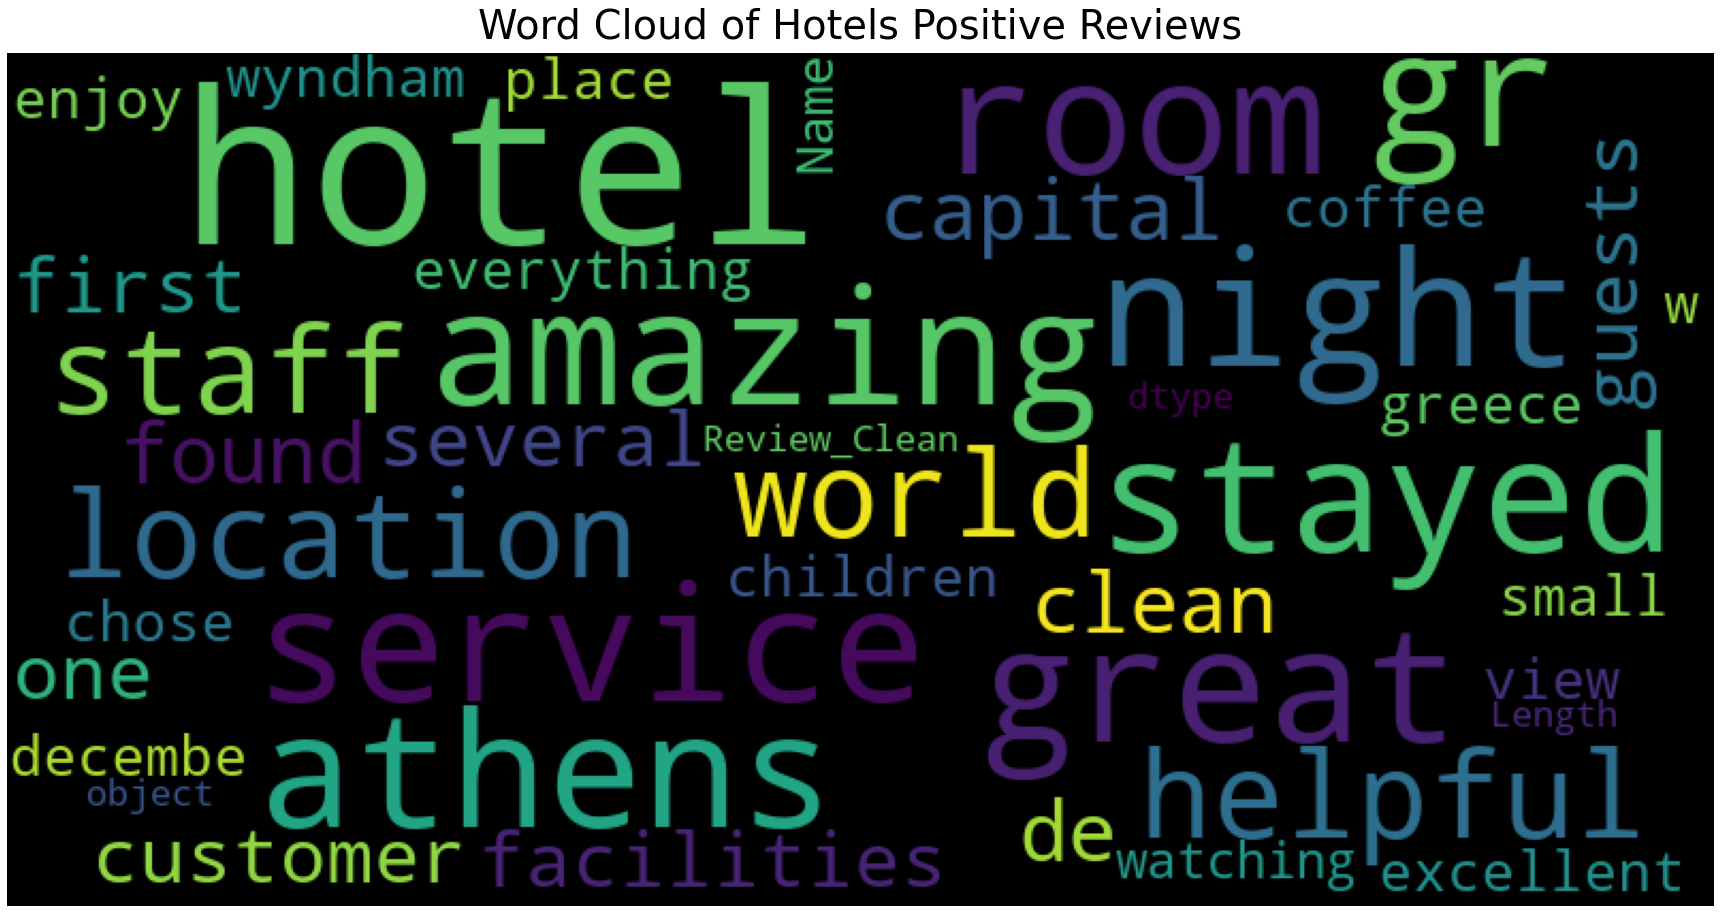

In [19]:
wordcloud.generate(str(df_pos['Review_Clean']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Hotels Positive Reviews", fontdict={'size': 40, 'color': 'black', 'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

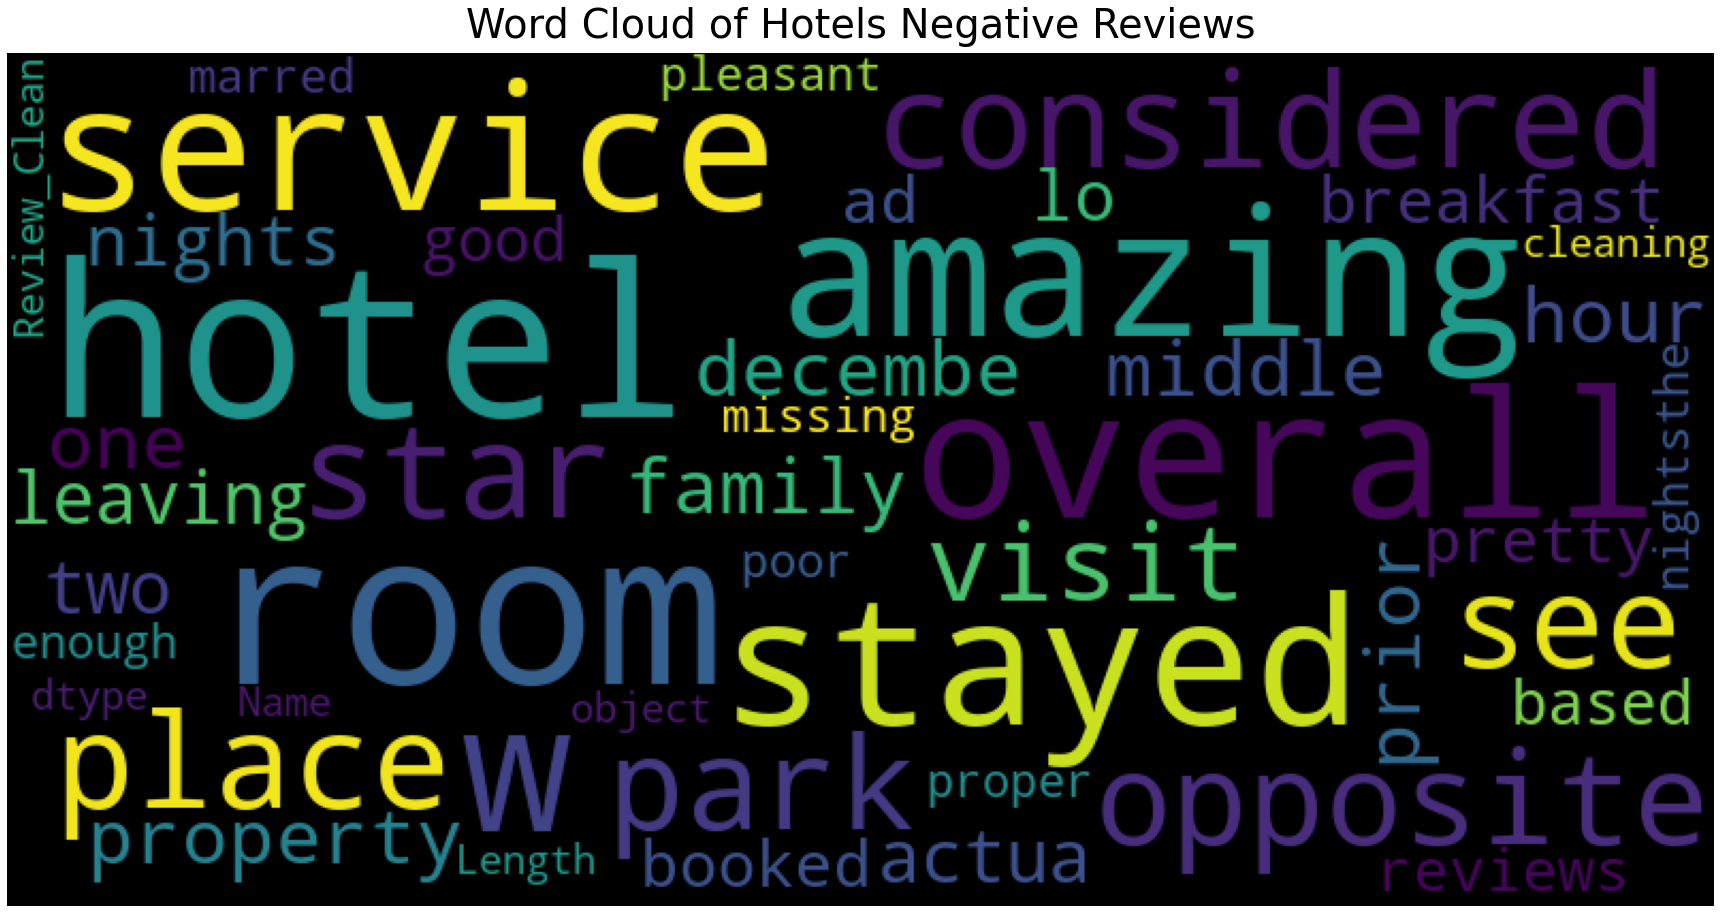

In [20]:
wordcloud.generate(str(df_neg['Review_Clean']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Hotels Negative Reviews", fontdict={'size': 40, 'color': 'black', 'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

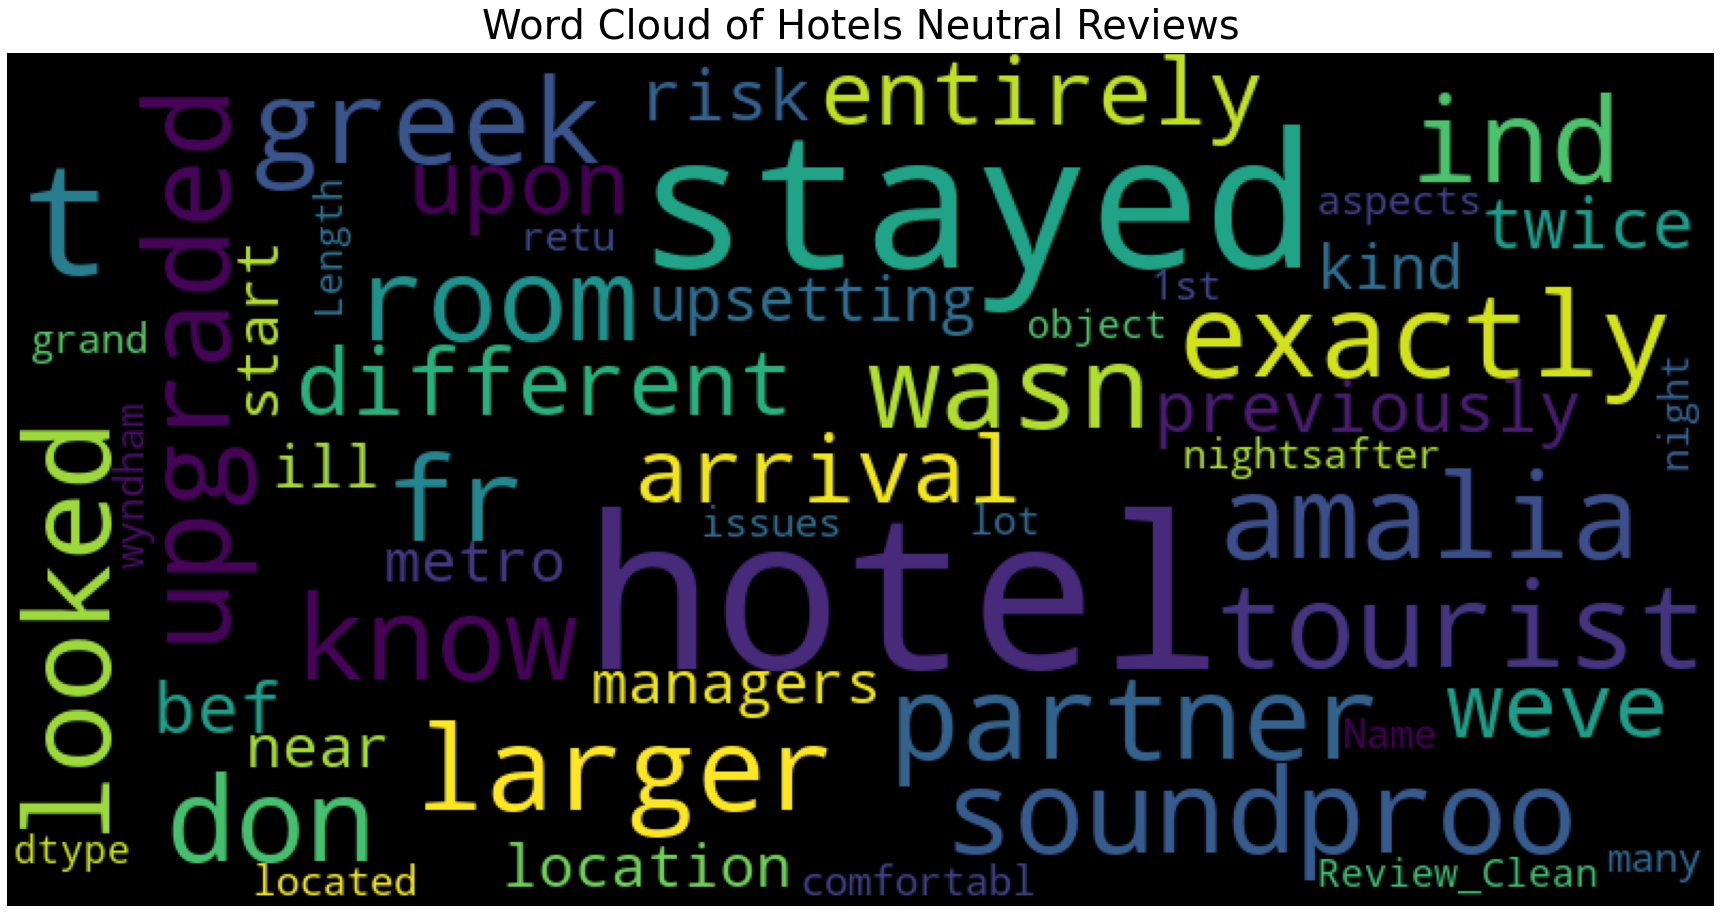

In [21]:
wordcloud.generate(str(df_notr['Review_Clean']))
plt.figure(figsize=(24.0,16.0))
plt.imshow(wordcloud);
plt.title(f"Word Cloud of Hotels Neutral Reviews", fontdict={'size': 40, 'color': 'black', 'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()  

Τα wordclouds δίνουν μια γενική ιδέα για το τι είναι κείμενο, αλλά χρειάζονται πιο χαρακτηριστικές λέξεις επειδή όλες οι λέξεις δεν βρίσκονται στο ίδιο κείμενο σε αυτά τα δεδομένα.

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
def word_count(reviews):
    word_num={}
    for i in reviews:
        token = nltk.word_tokenize(i)
        for t in token:
            if t not in word_num.keys():
                word_num[t] = 1
            else:
                word_num[t] += 1  
    return word_num

25 πιο κοινές λέξεις σε θετικές κριτικές

In [25]:
word_frequency=word_count(df_pos['Review_Clean'])

In [26]:
df_pos_count = pd.DataFrame(columns=['word', 'count'])
df_pos_count['word'] = word_frequency.keys()
df_pos_count['count'] = list(word_frequency.values())
df_pos_count=df_pos_count.sort_values(by=['count'], ascending=False)
df_pos_count=df_pos_count.reset_index(drop=True)

In [27]:
stop_words = set(STOPWORDS)

In [28]:
stop = set(stopwords.words("english"))

Θα δημιουργήσω νέα στήλη ως word_without_stop και θα κάνουμε drop τη σειρά εάν περιέχει ενδιάμεσες λέξεις.

In [29]:
df_pos_count['word_without_stop'] = df_pos_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [30]:
df_pos_without_stop = df_pos_count.dropna(subset=['word_without_stop'])

In [31]:
df_top_25_pos = df_pos_count.loc[df_pos_count['word_without_stop']!=''].head(25)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


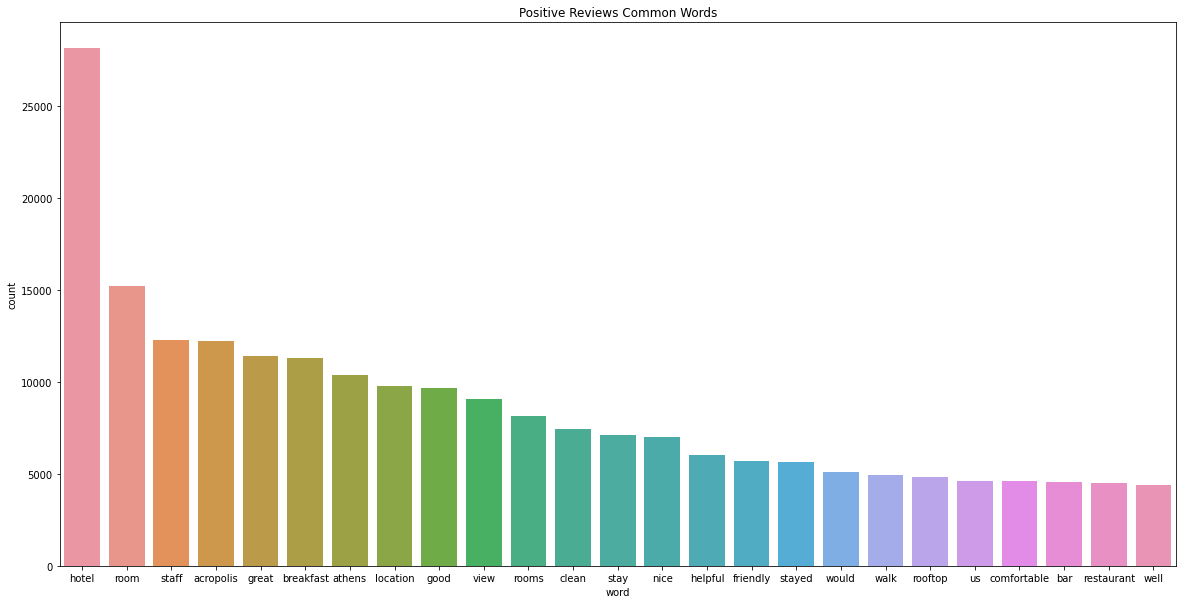

In [32]:
plt.figure(figsize=(20,10))
plt.title('Positive Reviews Common Words')
sns.barplot("word","count", data=df_top_25_pos)

25 πιο κοινές λέξεις σε αρνητικές κριτικές

In [33]:
word_frequency_neg=word_count(df_neg['Review_Clean'])

In [34]:
df_neg_count = pd.DataFrame(columns=['word', 'count'])
df_neg_count['word'] = word_frequency_neg.keys()
df_neg_count['count'] = list(word_frequency_neg.values())
df_neg_count=df_neg_count.sort_values(by=['count'], ascending=False)
df_neg_count=df_neg_count.reset_index(drop=True)

In [35]:
df_neg_count['word_without_stop'] = df_neg_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [36]:
df_neg_without_stop = df_neg_count.dropna(subset=['word_without_stop'])

In [37]:
df_top_25_neg = df_neg_count.loc[df_neg_count['word_without_stop']!=''].head(25)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


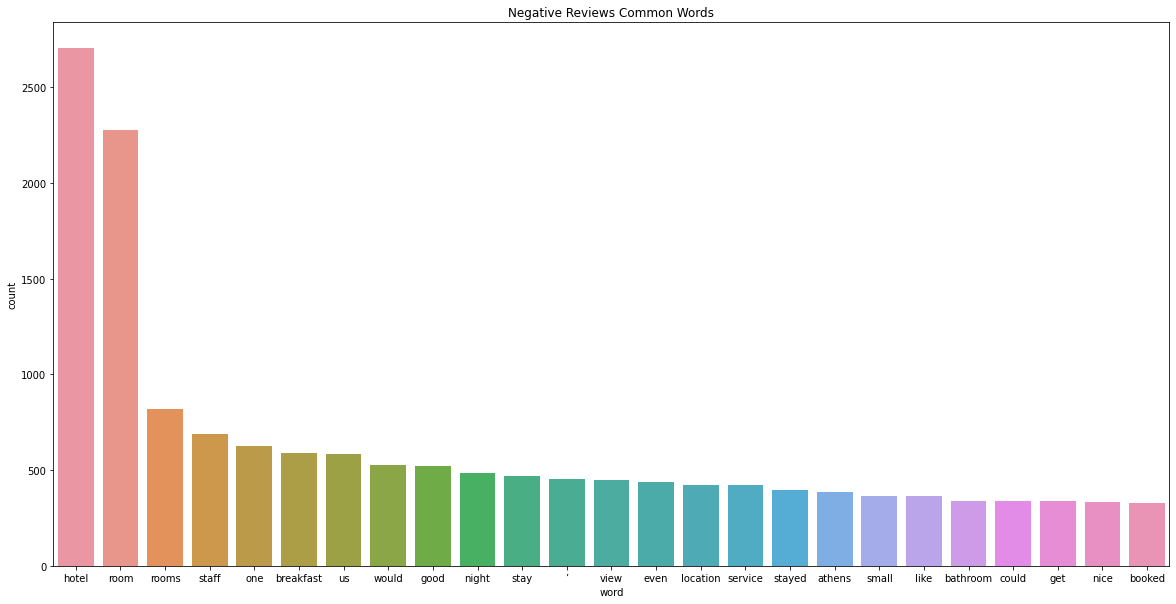

In [38]:
plt.figure(figsize=(20,10))
plt.title('Negative Reviews Common Words')
sns.barplot("word","count", data=df_top_25_neg)

25 πιο κοινές λέξεις σε neutral κριτικές

In [39]:
word_frequency_notr = word_count(df_notr['Review_Clean'])

In [40]:
df_nt_count = pd.DataFrame(columns=['word', 'count'])
df_nt_count['word'] = word_frequency_notr.keys()
df_nt_count['count'] = list(word_frequency_notr.values())
df_nt_count=df_nt_count.sort_values(by=['count'], ascending=False)
df_nt_count=df_nt_count.reset_index(drop=True)

In [41]:
df_nt_count['word_without_stop'] = df_nt_count['word'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

In [42]:
df_nt_without_stop = df_nt_count.dropna(subset=['word_without_stop'])

In [43]:
df_top_25_nt = df_nt_count.loc[df_nt_count['word_without_stop']!=''].head(25)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


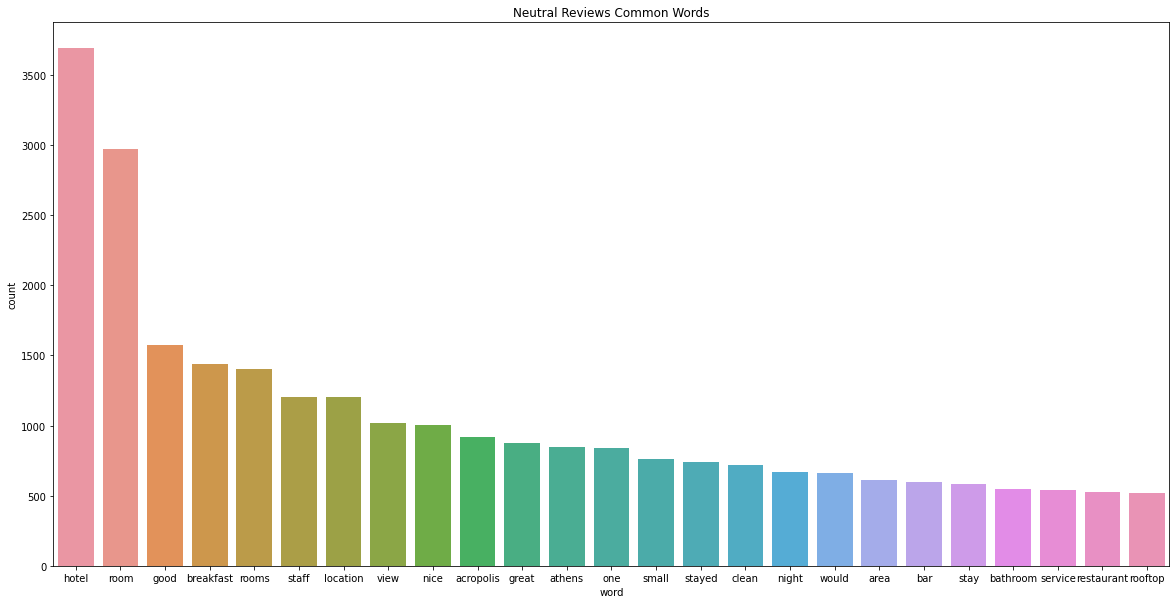

In [44]:
plt.figure(figsize=(20,10))
plt.title('Neutral Reviews Common Words')
sns.barplot("word","count", data=df_top_25_nt)

Παρατηρούμε παρόμοια αποτελέσματα. Πιθανότατα, ο λόγος είναι ότι ο υπολογιστής μετράει κάθε λέξη και αφαιρεί τα stopwords όπως το «δεν». Εάν οι πιο συνηθισμένες λέξεις είναι "δεν μου άρεσε" για αρνητικό, μετράται ως "μου αρέσει".

In [45]:
df

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean
0,1,amalia,"amazing hotel, great location and helpful staf...",5,admiration,2,amazing hotel great location and helpful staff...
1,2,amalia,"for a hotel in a world capital, our room was d...",4,admiration,2,for a hotel in a world capital our room was de...
2,3,amalia,we are here for 6 nights and found this hotel ...,5,admiration,2,we are here for 6 nights and found this hotel ...
3,4,amalia,"clean facilities, rooms. great customer servic...",5,admiration,2,clean facilities rooms great customer service ...
4,5,amalia,i have stayed in athens in several hotels and...,5,approval,2,i have stayed in athens in several hotels and...
...,...,...,...,...,...,...,...
23766,887,wyndham,i was one of the first guests and everything w...,5,admiration,2,i was one of the first guests and everything w...
23767,888,wyndham,we stayed with our 2 small children on decembe...,5,admiration,2,we stayed with our 2 small children on decembe...
23768,889,wyndham,excellent service and view of athens is the gr...,5,admiration,2,excellent service and view of athens is the gr...
23769,890,wyndham,i was in greece for 1 night. i chose wyndham g...,5,approval,2,i was in greece for 1 night i chose wyndham gr...


In [46]:
df.to_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Accommodation Reviews/cleaned_data.csv', index = False)

In [47]:
# δημιουργία νέας στήλης που αποτελείται από τους αριθμούς κριτικών κάθε χρήστη
df['Reviewer_Count'] = df['UserId'].map(df['UserId'].value_counts())

In [48]:
# δημιουργία νέας στήλης που αποτελείται από τους αριθμούς κριτικών κάθε εστιατορείου
df['Restaurant_Count'] = df['Name'].map(df['Name'].value_counts())

In [49]:
df = df.sort_values(by=['Reviewer_Count'],ascending=False)

In [50]:
df

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count
0,1,amalia,"amazing hotel, great location and helpful staf...",5,admiration,2,amazing hotel great location and helpful staff...,21,1378
10522,462,herodion,stayed here for 4 nights. arrived late past mi...,5,approval,2,stayed here for 4 nights arrived late past mid...,21,2000
10511,451,herodion,this place is pretty much perfect for those in...,5,admiration,2,this place is pretty much perfect for those in...,21,2000
10512,452,herodion,the hotel itself is average. the rooms are sma...,3,admiration,1,the hotel itself is average the rooms are smal...,21,2000
10513,453,herodion,the lovely and classic hotel herodion pleased ...,5,admiration,2,the lovely and classic hotel herodion pleased ...,21,2000
...,...,...,...,...,...,...,...,...,...
21835,1672,royal,my husband and i visited the royal olympic hot...,4,approval,2,my husband and i visited the royal olympic hot...,2,2000
21834,1671,royal,hotel is only 10 mins walking time to the hist...,3,admiration,1,hotel is only 10 mins walking time to the hist...,2,2000
21833,1670,royal,make no mistake about it this hotel is a great...,3,admiration,1,make no mistake about it this hotel is a great...,2,2000
21832,1669,royal,i stayed at royal olympic from sunday and chec...,5,approval,2,i stayed at royal olympic from sunday and chec...,2,2000


In [51]:
df.reset_index(drop=True,inplace=True) 

In [52]:
df.isna().sum()

UserId              0
Name                0
Review              0
Rating              0
Emotion             0
sentiment           0
Review_Clean        0
Reviewer_Count      0
Restaurant_Count    0
dtype: int64

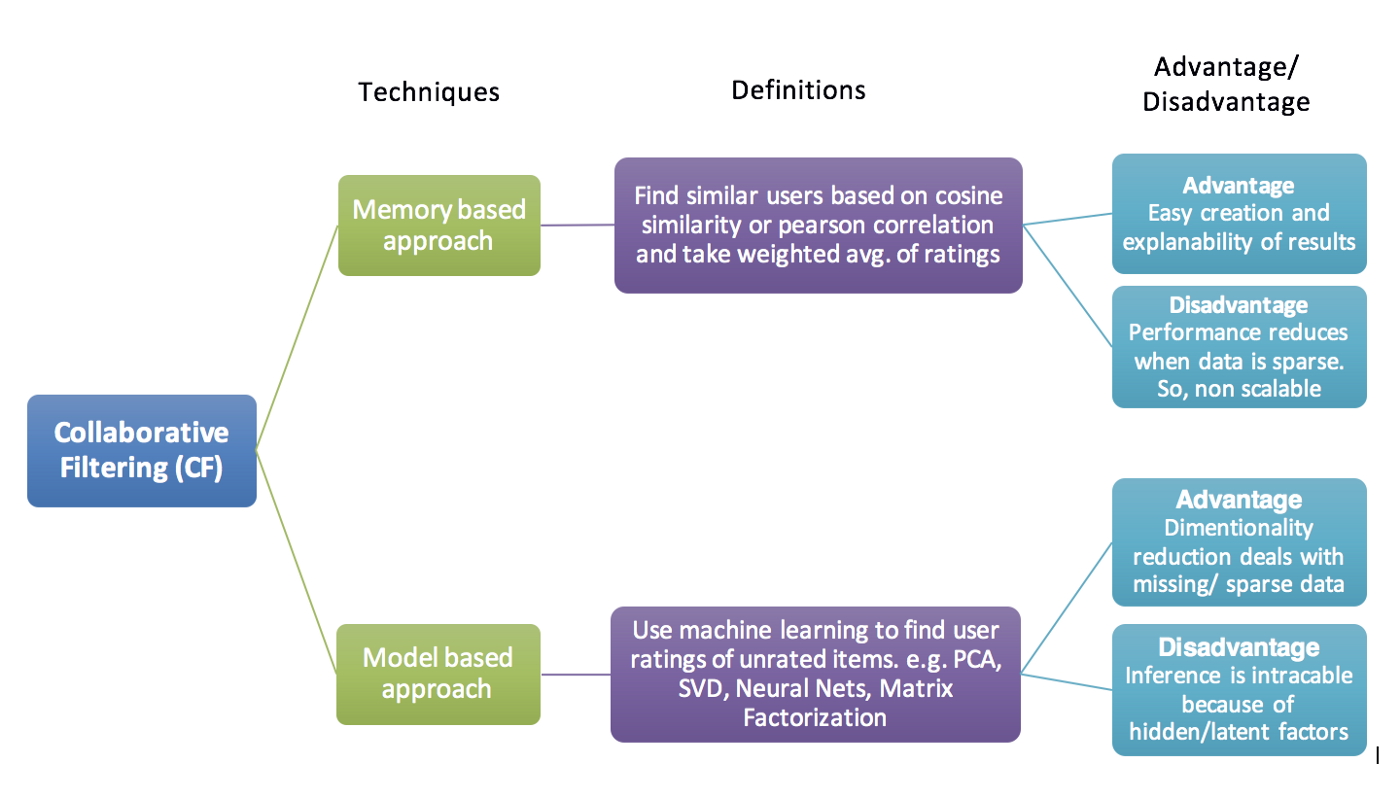

# Recommend with SVD - User Based

In [53]:
# κάνουμε pivot τον πίνακα
pivot = pd.pivot_table(df, index='UserId', columns=['Name'], values='Rating').fillna(0)
pivot.head(5)

Name,InterContinental,amalia,athens_gate,attalos,ava,central,cypria,electra_metropolis,grand_hyatt,hera,...,innathens,marble,melia,new,plaka_hotel,polis grand,president,royal,titania,wyndham
UserId,,,,,,,,,,,,,,,,,,,,,
1,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,...,5.0,5.0,4.0,5.0,5.0,5.0,3.0,3.0,2.0,5.0
2,5.0,4.0,5.0,5.0,5.0,4.0,3.0,5.0,3.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,1.0,5.0
3,5.0,5.0,5.0,5.0,5.0,1.0,4.0,4.0,4.0,2.0,...,5.0,5.0,5.0,5.0,5.0,5.0,2.0,4.0,5.0,5.0
4,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,3.0,...,5.0,5.0,3.0,5.0,5.0,5.0,1.0,5.0,5.0,5.0
5,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,1.0,4.0,...,4.0,5.0,5.0,5.0,5.0,5.0,3.0,2.0,3.0,2.0


In [54]:
pivot_mat = pivot.values
pivot_mat[:5]

array([[5., 5., 5., 5., 5., 4., 4., 5., 5., 5., 5., 5., 5., 4., 5., 5.,
        5., 3., 3., 2., 5.],
       [5., 4., 5., 5., 5., 4., 3., 5., 3., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 3., 1., 5.],
       [5., 5., 5., 5., 5., 1., 4., 4., 4., 2., 5., 5., 5., 5., 5., 5.,
        5., 2., 4., 5., 5.],
       [4., 5., 5., 5., 5., 4., 5., 5., 3., 3., 5., 5., 5., 3., 5., 5.,
        5., 1., 5., 5., 5.],
       [5., 5., 5., 4., 5., 5., 4., 5., 1., 4., 4., 4., 5., 5., 5., 5.,
        5., 3., 2., 3., 2.]])

In [55]:
# Η στήλη user id είναι index, οπότε το αποθηκεύουμαι σε μια λίστα
user_id = list(pivot.index)
user_id[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [56]:
sparse_matrix = csr_matrix(pivot_mat)
sparse_matrix

<2000x21 sparse matrix of type '<class 'numpy.float64'>'
	with 23771 stored elements in Compressed Sparse Row format>

In [57]:
# αριθμοί factor για τον πίνακα
factor_n = 15

In [58]:
# παραγοντοποίηση πίνακα
U, sigma, V = svds(sparse_matrix, k = factor_n)

In [59]:
# διαστάσεις πίνακα
print(U.shape)
print(V.shape)
sigma = np.diag(sigma)
print(sigma.shape)

(2000, 15)
(15, 21)
(15, 15)


In [60]:
pred_rating = np.dot(np.dot(U,sigma),V)
pred_rating[:5]

array([[4.99832997, 4.92584418, 4.36498047, 5.10660679, 4.8304552 ,
        4.0952812 , 4.57435412, 5.07475355, 4.80435492, 4.96769162,
        5.02832549, 5.40037571, 4.74818008, 4.10754589, 4.84428258,
        4.9057474 , 4.47455108, 3.13580623, 2.97786085, 2.9517599 ,
        4.99430066],
       [5.01451701, 3.76037842, 4.11797798, 5.18307432, 4.62448293,
        4.31094733, 3.85917719, 5.06620363, 3.98342102, 4.89381825,
        5.04281067, 4.54142196, 4.29707693, 5.21657211, 5.00330277,
        4.8759612 , 4.40205337, 5.06252302, 2.97481653, 2.71332585,
        4.77953511],
       [4.50198656, 5.06006484, 5.65763734, 5.07869698, 5.31187683,
        0.72211176, 4.36087175, 4.69857604, 4.18722196, 3.15441212,
        5.03637074, 4.78245944, 4.65807836, 4.83249516, 3.86145133,
        4.58010945, 4.93500406, 2.35808003, 3.93999325, 4.56671589,
        4.64494022],
       [3.65683058, 5.02918369, 5.72357695, 5.02994843, 5.22380642,
        3.82638914, 5.06784072, 5.17581742, 3.4852447

Πρέπει να κανονικοποιήσω τον πίνακα μου πριν το recommendation λόγω μηδενικών τιμών.

In [61]:
# κανονικοποίηση
pred_rating_n = (pred_rating - pred_rating.min()) / (pred_rating.max() - pred_rating.min())

In [62]:
pred_rating_n[:5]

array([[0.85942283, 0.84941273, 0.77195886, 0.87437559, 0.83623975,
        0.73471407, 0.80087284, 0.86997674, 0.83263537, 0.85519175,
        0.86356514, 0.91494433, 0.82487776, 0.73640779, 0.83814927,
        0.84663741, 0.78709029, 0.602213  , 0.58040114, 0.57679666,
        0.85886639],
       [0.86165822, 0.68846484, 0.73784844, 0.88493556, 0.8077955 ,
        0.76449702, 0.7021087 , 0.86879601, 0.71926646, 0.84499003,
        0.8655655 , 0.79632499, 0.76258155, 0.88956152, 0.86010956,
        0.84252401, 0.77707854, 0.86828773, 0.57998073, 0.54386952,
        0.82920781],
       [0.79087906, 0.86794826, 0.95047152, 0.87052131, 0.90272286,
        0.26888788, 0.77139146, 0.81802757, 0.74741086, 0.60478242,
        0.86467617, 0.82961166, 0.81243494, 0.83652146, 0.70242276,
        0.80166763, 0.85067768, 0.49481097, 0.7132692 , 0.79981801,
        0.8106206 ],
       [0.67416515, 0.86368365, 0.95957761, 0.86378926, 0.89056056,
        0.69758076, 0.86902209, 0.8839334 , 0.6504695

In [63]:
# ανάθεση του νέου πίνακα στο dataframes
pred_df = pd.DataFrame(pred_rating_n, columns = pivot.columns, index=user_id).transpose()
pred_df.head(15)

,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
Name,,,,,,,,,,,,,,,,,,,,,
InterContinental,0.859423,0.861658,0.790879,0.674165,0.841006,0.866478,0.822680,0.887463,0.349938,0.738375,...,0.167509,0.167095,0.168412,0.167095,0.168827,0.168412,0.167509,0.167095,0.169730,0.166191
amalia,0.849413,0.688465,0.867948,0.863684,0.839419,0.696146,0.581101,0.412209,0.811083,0.842750,...,0.169566,0.169666,0.169712,0.169666,0.169612,0.169712,0.169566,0.169666,0.169757,0.169521
athens_gate,0.771959,0.737848,0.950472,0.959578,0.839550,0.722244,0.958861,0.742713,0.694351,0.674218,...,0.170040,0.170258,0.171318,0.170258,0.171100,0.171318,0.170040,0.170258,0.172379,0.168979
attalos,0.874376,0.884936,0.870521,0.863789,0.735459,0.874432,0.861847,0.750510,0.733733,0.733310,...,0.169186,0.169190,0.168830,0.169190,0.168825,0.168830,0.169186,0.169190,0.168470,0.169546
ava,0.836240,0.807795,0.902723,0.890561,0.843002,0.825341,0.878944,0.773778,0.783646,0.825688,...,0.170695,0.171078,0.170487,0.171078,0.170105,0.170487,0.170695,0.171078,0.169896,0.171286
central,0.734714,0.764497,0.268888,0.697581,0.878148,0.893358,0.296321,0.778504,0.800304,0.749201,...,0.167957,0.167655,0.168156,0.167655,0.168458,0.168156,0.167957,0.167655,0.168656,0.167457
cypria,0.800873,0.702109,0.771391,0.869022,0.761802,0.885501,0.710248,0.485947,0.711537,0.859855,...,0.167130,0.166621,0.166580,0.166621,0.167089,0.166580,0.167130,0.166621,0.166540,0.167170
electra_metropolis,0.869977,0.868796,0.818028,0.883933,0.881078,0.866180,0.882638,0.595141,0.851155,0.864892,...,0.170672,0.171049,0.170567,0.171049,0.170190,0.170567,0.170672,0.171049,0.170085,0.171154
grand_hyatt,0.832635,0.719266,0.747411,0.650470,0.448755,0.688753,0.688741,0.738187,0.558833,0.679579,...,0.167792,0.167449,0.167549,0.167449,0.167893,0.167549,0.167792,0.167449,0.167650,0.167692


Τώρα,υπάρχει η παραγοντοποίηση SVD κάθε χρήστη για κάθε ξενοδοχείο. Είναι ώρα για την τα recommendations.

In [64]:
def recommend_hotels(user_id ,pred_df, items_df, hotels_to_ignore=[], top_list=20, verbose=False):
      
        # αυτή η συνάρτηση βρήσκει τα πιο σχετικά στοιχεία
        sorted_user_predictions = pred_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        recommendations_df = sorted_user_predictions[~sorted_user_predictions['Name'].isin(hotels_to_ignore)].sort_values(by='recStrength', ascending = False).head(top_list)
        print(recommendations_df)
        return recommendations_df


In [65]:
def recommender(user_id,pred_df,real_df,df_meta):
   
    #αυτή η συνάρτησησ συγχωνεύει τον τίτλο με το αντίστοιχο αναγνωριστικό εστιατορίου και βρίσκει τις κενές σειρές δηλαδή τα εστιατόρεια που δεν έχει επισκεφθεί ο χρήστης
    hotels_to_ignore = df[df['UserId'] == str(user_id)]['Name'].values
    recommend = recommend_hotels(user_id, pred_df,real_df, hotels_to_ignore)
    df_user= real_df.loc[real_df['UserId'] == user_id]
    new_df = df_user.merge(recommend, how = 'outer', left_on = 'Name', right_on = 'Name')
    rec_df = new_df.loc[new_df['Rating'].isnull()==True]
    df_rec_t = rec_df.loc[:, ['Name', 'recStrength']]
    df_last = pd.merge(df_rec_t,df_meta[['HotelId','Name']],on=['Name'], how='left')
    df_last = df_last.drop_duplicates(subset=["Name", "HotelId"], keep='first')
    df_last = df_last.reset_index(drop=True) 
    return df_last

In [66]:
hotels = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Accommodation Reviews/hotels.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Accommodation Reviews/ratings.csv')
df_meta = hotels.merge(ratings, how="left", on="HotelId")
df_meta = df_meta.astype({"UserId": str, "HotelId": str})
df_meta.head()

,HotelId,Name,UserId,Review,Rating
0,1,amalia,1,"Amazing hotel, great location and helpful staf...",5
1,1,amalia,2,"For a hotel in a world capital, our room was d...",4
2,1,amalia,3,We are here for 6 nights and found this Hotel ...,5
3,1,amalia,4,"Clean facilities, rooms. Great customer servic...",5
4,1,amalia,5,I have stayed In Athens in several hotels and...,5


In [67]:
df = df.astype({"UserId": str})
df

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count
0,1,amalia,"amazing hotel, great location and helpful staf...",5,admiration,2,amazing hotel great location and helpful staff...,21,1378
1,462,herodion,stayed here for 4 nights. arrived late past mi...,5,approval,2,stayed here for 4 nights arrived late past mid...,21,2000
2,451,herodion,this place is pretty much perfect for those in...,5,admiration,2,this place is pretty much perfect for those in...,21,2000
3,452,herodion,the hotel itself is average. the rooms are sma...,3,admiration,1,the hotel itself is average the rooms are smal...,21,2000
4,453,herodion,the lovely and classic hotel herodion pleased ...,5,admiration,2,the lovely and classic hotel herodion pleased ...,21,2000
...,...,...,...,...,...,...,...,...,...
23766,1672,royal,my husband and i visited the royal olympic hot...,4,approval,2,my husband and i visited the royal olympic hot...,2,2000
23767,1671,royal,hotel is only 10 mins walking time to the hist...,3,admiration,1,hotel is only 10 mins walking time to the hist...,2,2000
23768,1670,royal,make no mistake about it this hotel is a great...,3,admiration,1,make no mistake about it this hotel is a great...,2,2000
23769,1669,royal,i stayed at royal olympic from sunday and chec...,5,approval,2,i stayed at royal olympic from sunday and chec...,2,2000


In [68]:
recommender(1000,pred_df,df,df_meta)

           Name  recStrength
13      titania     0.195052
14    innathens     0.190553
15       cypria     0.189853
16      wyndham     0.174804
17       marble     0.167774
18  athens_gate     0.158412
19  grand_hyatt     0.156586
20  polis grand     0.131147


,Name,recStrength,HotelId
0,titania,0.195052,20
1,innathens,0.190553,11
2,cypria,0.189853,6
3,wyndham,0.174804,21
4,marble,0.167774,13
5,athens_gate,0.158412,2
6,grand_hyatt,0.156586,8
7,polis grand,0.131147,17


# Recommend with Cosine Similarity - User Based

In [69]:
user_sparse_pivot = sparse.csr_matrix(pivot.fillna(0))
user_recommender = pw.cosine_similarity(user_sparse_pivot)

In [70]:
pred_rating_n_cos = (user_recommender - user_recommender.mean())/ (user_recommender.max() - user_recommender.min())

In [71]:
user_recommender_df = pd.DataFrame(pred_rating_n_cos, columns=pivot.index.values,index = pivot.index.values)

Στην μέθοδο αυτή, έχουμε ένα user-user matrix, που δείχνει τις σχέσεις τους και με βάζει αυτόν θα γίνουν οι συστάσεις.

In [72]:
user_recommender_df.head(3)

,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
1,0.387891,0.373467,0.349043,0.354145,0.348460,0.375886,0.326415,0.328688,0.318473,0.360689,...,-0.389820,-0.389820,-0.383695,-0.389820,-0.382609,-0.383695,-0.389820,-0.389820,-0.381049,-0.399430
2,0.373467,0.387891,0.328538,0.326817,0.352334,0.378099,0.325006,0.348190,0.310071,0.334340,...,-0.386563,-0.386563,-0.380368,-0.386563,-0.379269,-0.380368,-0.386563,-0.386563,-0.377692,-0.396283
3,0.349043,0.328538,0.387891,0.363221,0.321859,0.323404,0.359940,0.275698,0.266709,0.307067,...,-0.345968,-0.345968,-0.343944,-0.345968,-0.344105,-0.343944,-0.345968,-0.345968,-0.346924,-0.352013


In [73]:
def recommend2(user_recommender_df,user_id,df_meta):
    #Αυτή η συνάρτηση βρίσκει πρώτα τους 2 πιο όμοιους χρήστες και μετά 
    #παίρνει τον μέσο όρο των αξιολογήσεών τους στα εστιατόρεια και τα ταξινομεί σύμφωνα με τις μέσες τιμές
    user_cosine_df = pd.DataFrame(user_recommender_df[user_id].sort_values(ascending=False))
    user_cosine_df.reset_index(level=0, inplace=True)
    user_cosine_df.columns = ['Name','cosine_sim']
    
    # για 2 όμοιους χρήστες
    similar_user = list(user_cosine_df['Name'][1:3].values)
    similar_user_df = pivot.T[[user_id] + similar_user]
    similar_user_df['mean'] = similar_user_df[similar_user].mean(numeric_only=True,axis=1)
    similar_user_df.sort_values('mean', ascending=False,inplace = True)
    
    # πέρνουμε 10 εστιατόρια από παρόμοιους χρήστες και γίνεται η συγχώνευσή τους
    restaurant_top10 = similar_user_df[similar_user_df[user_id]==0].head(10)
    df_last1 = pd.merge(restaurant_top10,df_meta[['HotelId','Name']],on=['Name'], how='left')
    df_last1 = df_last1.drop_duplicates(subset=["Name", "HotelId"], keep='first')
    df_last1 = df_last1.reset_index(drop=True) 
    return df_last1

In [74]:
recommend2(user_recommender_df,1000,df_meta)

,Name,1000,914,967,mean,HotelId
0,grand_hyatt,0.0,0.0,0.0,0.0,8
1,cypria,0.0,0.0,0.0,0.0,6
2,innathens,0.0,0.0,0.0,0.0,11
3,marble,0.0,0.0,0.0,0.0,13
4,polis grand,0.0,0.0,0.0,0.0,17
5,athens_gate,0.0,0.0,0.0,0.0,2
6,titania,0.0,0.0,0.0,0.0,20
7,wyndham,0.0,0.0,0.0,0.0,21


# Recommendations from Keywords

## Recommending based on cosine similarity of reviews

In [75]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import math
from collections import Counter
import operator

In [76]:
stop = set(stopwords.words("english")) #σετάρουμε τα stopwords

In [77]:
df

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count
0,1,amalia,"amazing hotel, great location and helpful staf...",5,admiration,2,amazing hotel great location and helpful staff...,21,1378
1,462,herodion,stayed here for 4 nights. arrived late past mi...,5,approval,2,stayed here for 4 nights arrived late past mid...,21,2000
2,451,herodion,this place is pretty much perfect for those in...,5,admiration,2,this place is pretty much perfect for those in...,21,2000
3,452,herodion,the hotel itself is average. the rooms are sma...,3,admiration,1,the hotel itself is average the rooms are smal...,21,2000
4,453,herodion,the lovely and classic hotel herodion pleased ...,5,admiration,2,the lovely and classic hotel herodion pleased ...,21,2000
...,...,...,...,...,...,...,...,...,...
23766,1672,royal,my husband and i visited the royal olympic hot...,4,approval,2,my husband and i visited the royal olympic hot...,2,2000
23767,1671,royal,hotel is only 10 mins walking time to the hist...,3,admiration,1,hotel is only 10 mins walking time to the hist...,2,2000
23768,1670,royal,make no mistake about it this hotel is a great...,3,admiration,1,make no mistake about it this hotel is a great...,2,2000
23769,1669,royal,i stayed at royal olympic from sunday and chec...,5,approval,2,i stayed at royal olympic from sunday and chec...,2,2000


In [78]:
df['word_without_stop'] = df['Review_Clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [79]:
def cosine_similarity_of(text1, text2):
        
        # διαβάζουμε τις λέξεις
        first = re.compile(r"[\w']+").findall(text1)
        second = re.compile(r"[\w']+").findall(text2)

        # δημιουργεία λεξιλογίου
        vector1 = Counter(first)
        vector2 = Counter(second)

        # αλλάζοντας διανύσματα σε σύνολα για να βρούμε κοινές λέξεις με τομή
        common = set(vector1.keys()).intersection(set(vector2.keys()))

        dot_product = 0.0

        for i in common:
          
            dot_product += vector1[i] * vector2[i]

        squared_sum_vector1 = 0.0
        squared_sum_vector2 = 0.0

        # άθροισμα των μετρήσεων λέξεων για κάθε διάνυσμα
        for i in vector1.keys():
            squared_sum_vector1 += vector1[i]**2

        for i in vector2.keys():
            squared_sum_vector2 += vector2[i]**2

        # υπολογισμός του μεγέθους του διανύσματος με άθροισμα τετραγώνων
        magnitude = math.sqrt(squared_sum_vector1) * math.sqrt(squared_sum_vector2)

        if not magnitude:
            return 0.0
        else:
            return float(dot_product) / magnitude

In [80]:
text1 = df['word_without_stop'][1] 
text2 = df['word_without_stop'][2] 
cosine_similarity_of(text1, text2)

0.12326312688558734

In [81]:
def get_recommendations(df,keywords):

        score_dict = {}

        for index, row in df.iterrows():
            score_dict[index] = cosine_similarity_of(row['word_without_stop'], keywords)

        # κάνουμε sort τα εστιατόρεια σύμφωνα με τα similarities
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        # δημιουργία νέου dataframe
        result = pd.DataFrame(columns=('UserId', 'Name','word_without_stop', 'score'))

        # κρατάμε αυτά με το μεγαλύτερο score
        for i in sorted_scores:
            result = result.append({'UserId': df.iloc[i[0]]['UserId'], 
                                        'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>15:
                break

        return result



In [82]:
keywords = "best place ever"

In [83]:
top_10= get_recommendations(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,UserId,Name,word_without_stop,score
0,1206,attalos,absolutely best value greece quaint 6 story ho...,0.514496
1,94,electra_metropolis,best spa treatment last years dimitra flora ma...,0.487950
2,178,president,honestly best choice athens excellent mood pla...,0.397360
3,1335,royal,best hotel ever best breakfast buffet best ser...,0.396059
4,251,polis grand,great hotel comfortable clean rooms breakfast ...,0.379663
5,43,cypria,hotel best place want visit center townour roo...,0.377964
6,1196,ava,athens overnight found staff exceptional rooms...,0.361158
7,424,wyndham,many times visited city athens love view acrop...,0.356348
8,88,athens_gate,hotel total worth priced pretty reasonable lov...,0.339683
9,874,hera,ended havng go solo trip athens couldnt found ...,0.335578


## Rating Effect Adding

θα προσθέσω ένα weight του rating στη λειτουργία του συστήματος. Για να γίνει αυτό, θα καθορίσω πόσο θέλω να επηρεάστουν τα αποτελέσματα. Θα χρησιμοποιήσω απλή μαθηματική εξίσωση, weigth = (2*Q/5)*rating - Q. 

Το Q καθορίζει πόσο θα επηρεάσει. Για Q=10 και rating = 5, το cosine similarity αυξάνεται κατά 10%.

In [84]:
def rating_weight(rating,Q):
    #υπολογισμός του βάρους του rating
    w = (2*Q/5)*rating - Q
    return w

In [85]:
def calculate_final_score(cos_sim, w):
        # προσθέτοντας την επίδραση του βάρους στο cosine similarity
        effect = (cos_sim / 100) * w
        return cos_sim + effect

In [86]:
def get_recommendations_rat(df,keywords):
        score_dict = {}

        for index, row in df.iterrows():
            cs_score = cosine_similarity_of(row['word_without_stop'], keywords)

            rating = row['Rating']
            
            # Επιλέγουμε Q=10
            rating_effect = rating_weight(rating,10)

            last_score = calculate_final_score(cs_score, rating_effect)

            score_dict[index] = last_score
            
        # κάνουμε sort τα εστιατόρεια σύμφωνα με τα similaritiess
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        # δημιουργία νέου dataframe
        result = pd.DataFrame(columns=('Name', 'word_without_stop', 'Rating', 'score'))

         #  κρατάμε αυτά με το μεγαλύτερο score
        for i in sorted_scores:
              

            result = result.append({'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'Rating': df.iloc[i[0]]['Rating'],
                                        'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>15:
                break
                
        return result



In [87]:
keywords = "best restaurant ever"

In [88]:
top_10= get_recommendations_rat(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,Name,word_without_stop,Rating,score
0,royal,best hotel ever best breakfast buffet best ser...,5,0.544581
1,athens_gate,hotel total worth priced pretty reasonable lov...,5,0.498202
2,amalia,room given nice hotel staff excellent helpful ...,4,0.454576
3,wyndham,best hotel amazing staff always watching us wh...,5,0.429396
4,polis grand,great hotel comfortable clean rooms breakfast ...,5,0.417630
5,ava,athens overnight found staff exceptional rooms...,5,0.397273
6,electra_metropolis,exquisite hotel best location athensperfect ro...,4,0.391431
7,hera,ended havng go solo trip athens couldnt found ...,5,0.369136


## Number of Ratings Effect

Είναι δύσκολο να πούμε ότι το εστιατόριο που έχει μέση βαθμολογία 5 με μόνο 8 σχόλια είναι καλύτερο από το εστιατόριο που βαθμολογήθηκε με 4 με 2000 κριτικές. Περισσότερες κριτικές για το προϊόν σημαίνει μεγαλύτερη αξιοπιστία.

Έτσι, θα προσθέσω πολλαπλασιαστή στη συνάρτηση βαθμολόγησης που δίνει μικρότερο αποτέλεσμα εάν η βαθμολογία είναι μικρότερη από το όριο.

Θα χρησιμοποιήσουμε ως multipier to e^(({-t)*0.68)/ratingsnumber)

In [89]:
math.exp(-0.68) # όταν το t ισούται με τον αριθμό των ratings.

0.5066169923655895

In [90]:
def get_rating_weight_with_threshold(rating, count, threshold, Q):
            # υπολογισμός του βάρους του rating
            w = (2*Q/5)*rating - Q
            # multiplier
            M = math.exp((-threshold*0.68)/count)

            return w * M

In [91]:
df

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count,word_without_stop
0,1,amalia,"amazing hotel, great location and helpful staf...",5,admiration,2,amazing hotel great location and helpful staff...,21,1378,amazing hotel great location helpful staff fac...
1,462,herodion,stayed here for 4 nights. arrived late past mi...,5,approval,2,stayed here for 4 nights arrived late past mid...,21,2000,stayed 4 nights arrived late past midnight giv...
2,451,herodion,this place is pretty much perfect for those in...,5,admiration,2,this place is pretty much perfect for those in...,21,2000,place pretty much perfect interested acropolis...
3,452,herodion,the hotel itself is average. the rooms are sma...,3,admiration,1,the hotel itself is average the rooms are smal...,21,2000,hotel average rooms small halls felt odd said ...
4,453,herodion,the lovely and classic hotel herodion pleased ...,5,admiration,2,the lovely and classic hotel herodion pleased ...,21,2000,lovely classic hotel herodion pleased every wa...
...,...,...,...,...,...,...,...,...,...,...
23766,1672,royal,my husband and i visited the royal olympic hot...,4,approval,2,my husband and i visited the royal olympic hot...,2,2000,husband visited royal olympic hotel end august...
23767,1671,royal,hotel is only 10 mins walking time to the hist...,3,admiration,1,hotel is only 10 mins walking time to the hist...,2,2000,hotel 10 mins walking time historical sites ro...
23768,1670,royal,make no mistake about it this hotel is a great...,3,admiration,1,make no mistake about it this hotel is a great...,2,2000,make mistake hotel great base see top attracti...
23769,1669,royal,i stayed at royal olympic from sunday and chec...,5,approval,2,i stayed at royal olympic from sunday and chec...,2,2000,stayed royal olympic sunday checked wednesday ...


In [92]:
def get_recommendations_rat_count(df,keywords):

        score_dict = {}

        for index, row in df.iterrows():
            cs = cosine_similarity_of(row['word_without_stop'], keywords)

            rating = row['Rating']
            rating_count = row['Restaurant_Count']
            threshold = 110
           
            rating_contribution = get_rating_weight_with_threshold(rating,rating_count,threshold,10)

            last_score = calculate_final_score(cs, rating_contribution)

            score_dict[index] = last_score
            
     
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0


        result = pd.DataFrame(columns=('Name', 'word_without_stop', 'Rating', 'score'))
        
        for i in sorted_scores:
            
            result = result.append({'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'Rating': df.iloc[i[0]]['Rating'],
                                        'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>15:
                break
                
        return result

In [93]:
keywords = "best restaurant ever"
top_10 = get_recommendations_rat_count(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,Name,word_without_stop,Rating,score
0,royal,best hotel ever best breakfast buffet best ser...,5,0.542764
1,athens_gate,hotel total worth priced pretty reasonable lov...,5,0.493703
2,amalia,room given nice hotel staff excellent helpful ...,4,0.453216
3,wyndham,best hotel amazing staff always watching us wh...,5,0.426253
4,polis grand,great hotel comfortable clean rooms breakfast ...,5,0.414241
5,ava,athens overnight found staff exceptional rooms...,5,0.395624
6,electra_metropolis,exquisite hotel best location athensperfect ro...,4,0.389834
7,hera,ended havng go solo trip athens couldnt found ...,5,0.367033


## Positive Review Effect

Τώρα, θέλω να δώσω μεγαλύτερη βαρύτητα στη βαθμολογία μου εάν η κριτική είναι θετική. Για να γίνει αυτό, θα δημιουργήσω νέες στήλες που είναι True όταν η βαθμολογία είναι ίση ή μεγαλύτερη από 3.

Θέτουμε newrating = rating + (7 - rating)/2 = (rating+7)/2

In [94]:
df['positive'] = df['Rating'].apply(lambda x: True if x>=3 else False)

In [95]:
def get_recommendations_rat_count_pos(df,keywords):

        score_dict = {}

        for index, row in df.iterrows():
            cs = cosine_similarity_of(row['word_without_stop'], keywords)

            rating = row['Rating']
            rating_count = row['Restaurant_Count']
            
            if row['positive']==True:
                pos_rat = (7+rating)/2
            else:
                pos_rat = rating/2
                
            threshold=110
            
            rating_contribution =get_rating_weight_with_threshold(pos_rat,rating_count,threshold,10)

            last_score = calculate_final_score(cs, rating_contribution)
   
            score_dict[index] = last_score

        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        result = pd.DataFrame(columns=('Name', 'word_without_stop', 'Rating', 'score'))

        for i in sorted_scores:
            
            result = result.append({'Name': df.iloc[i[0]]['Name'],
                                        'word_without_stop': df.iloc[i[0]]['word_without_stop'], 
                                        'Rating': df.iloc[i[0]]['Rating'],
                                        'score': i[1]}, ignore_index=True)
            
            counter += 1

            if counter>15:
                break
                
        return result

In [96]:
keywords = "best food ever"
top_10= get_recommendations_rat_count_pos(df,keywords)
top_10 = top_10.drop_duplicates(subset=['Name'], keep='first')
top_10 = top_10.reset_index(drop=True) 
top_10

,Name,word_without_stop,Rating,score
0,wyndham,many times visited city athens love view acrop...,5,0.502775
1,royal,best hotel ever best breakfast buffet best ser...,5,0.449472
2,titania,best pick room small musty shower impossible b...,3,0.440639
3,ava,athens overnight found staff exceptional rooms...,5,0.409410
4,athens_gate,stayed 3 different hotels athens best location...,5,0.398134
5,polis grand,fine dining restaurant normal food service sec...,5,0.390579
6,electra_metropolis,husband arrived mini honeymoon massages marina...,5,0.383811
7,amalia,breakfast hotel one best ever seen buffet amaz...,4,0.364531
8,new,started read bad reviews really dont underatan...,5,0.362703
9,hera,loved nice friendly great location rooftop res...,5,0.362283


In [98]:
#df.to_csv('/content/drive/MyDrive/ΕΙΔΙΚΟ ΘΕΜΑ/Accommodation Reviews/hotels_for_keywords_recommendation.csv', index = False)

In [99]:
df

,UserId,Name,Review,Rating,Emotion,sentiment,Review_Clean,Reviewer_Count,Restaurant_Count,word_without_stop,positive
0,1,amalia,"amazing hotel, great location and helpful staf...",5,admiration,2,amazing hotel great location and helpful staff...,21,1378,amazing hotel great location helpful staff fac...,True
1,462,herodion,stayed here for 4 nights. arrived late past mi...,5,approval,2,stayed here for 4 nights arrived late past mid...,21,2000,stayed 4 nights arrived late past midnight giv...,True
2,451,herodion,this place is pretty much perfect for those in...,5,admiration,2,this place is pretty much perfect for those in...,21,2000,place pretty much perfect interested acropolis...,True
3,452,herodion,the hotel itself is average. the rooms are sma...,3,admiration,1,the hotel itself is average the rooms are smal...,21,2000,hotel average rooms small halls felt odd said ...,True
4,453,herodion,the lovely and classic hotel herodion pleased ...,5,admiration,2,the lovely and classic hotel herodion pleased ...,21,2000,lovely classic hotel herodion pleased every wa...,True
...,...,...,...,...,...,...,...,...,...,...,...
23766,1672,royal,my husband and i visited the royal olympic hot...,4,approval,2,my husband and i visited the royal olympic hot...,2,2000,husband visited royal olympic hotel end august...,True
23767,1671,royal,hotel is only 10 mins walking time to the hist...,3,admiration,1,hotel is only 10 mins walking time to the hist...,2,2000,hotel 10 mins walking time historical sites ro...,True
23768,1670,royal,make no mistake about it this hotel is a great...,3,admiration,1,make no mistake about it this hotel is a great...,2,2000,make mistake hotel great base see top attracti...,True
23769,1669,royal,i stayed at royal olympic from sunday and chec...,5,approval,2,i stayed at royal olympic from sunday and chec...,2,2000,stayed royal olympic sunday checked wednesday ...,True
